In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d benedictusjason/fruq-db
!unzip -q fruq-db.zip -d fruits_dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/benedictusjason/fruq-db
License(s): MIT
100% 229M/230M [00:00<00:00, 597MB/s]
100% 230M/230M [00:00<00:00, 626MB/s]


In [ ]:
dataset_path = "/content/fruits_dataset/FruQ-DB"

In [ ]:
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4519 images belonging to 3 classes.
Found 1128 images belonging to 3 classes.


In [ ]:
base_model = MobileNetV2(input_shape=(img_size, img_size, 3),
                         include_top=False,
                         weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
      layer.trainable = False

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 108s 633ms/step - accuracy: 0.5959 - loss: 0.9161 - val_accuracy: 0.9043 - val_loss: 0.3834
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 580ms/step - accuracy: 0.8952 - loss: 0.3058 - val_accuracy: 0.8316 - val_loss: 0.3370
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 581ms/step - accuracy: 0.9397 - loss: 0.1846 - val_accuracy: 0.8706 - val_loss: 0.2670
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 581ms/step - accuracy: 0.9570 - loss: 0.1457 - val_accuracy: 0.8723 - val_loss: 0.2464
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 576ms/step - accuracy: 0.9652 - loss: 0.1152 - val_accuracy: 0.8874 - val_loss: 0.2245
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 77s 545ms/step - accuracy: 0.9786 - loss: 0.0897 - val_accuracy: 0.8715 - val_loss: 0.2722
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 77s 539ms/step - accuracy: 0.9794 - loss: 0.0816 - val_accuracy: 0.8590 - val_loss: 0.3079
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 77s 546ms/step - accuracy: 0.9766 - loss: 

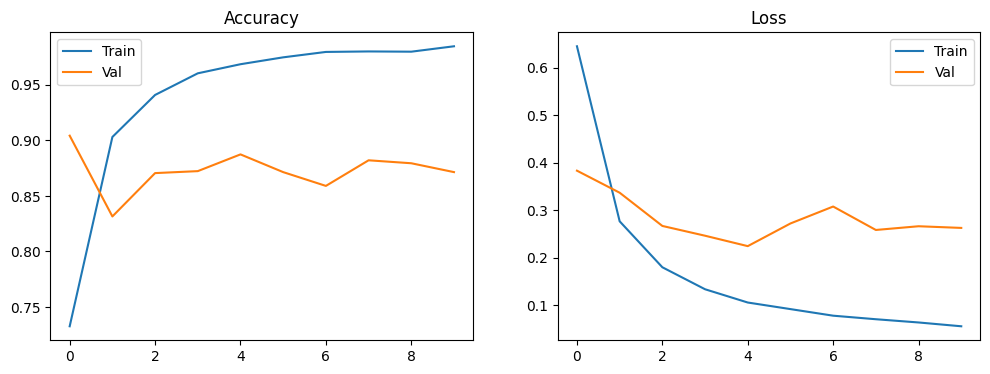

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 503ms/step


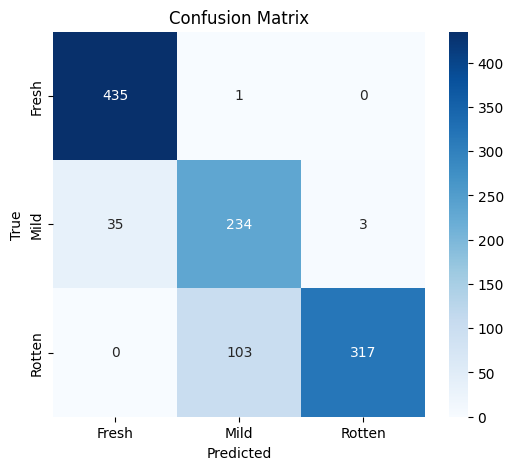

In [ ]:
val_generator.reset()
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

class_labels = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

       Fresh       0.93      1.00      0.96       436
        Mild       0.69      0.86      0.77       272
      Rotten       0.99      0.75      0.86       420

    accuracy                           0.87      1128
   macro avg       0.87      0.87      0.86      1128
weighted avg       0.89      0.87      0.88      1128



In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/mobilenetv2_fruit_freshness.keras")